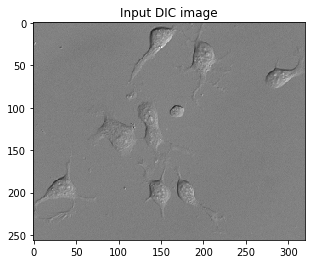

In [246]:
import numpy as np, scipy, skimage, time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy import ndimage
import imageio
import matplotlib.pyplot as plt

#read image
g = np.double(imageio.imread("DICImage.tif"))
nrows, ncols = g.shape
N = nrows*ncols

xx, yy = np.meshgrid(np.arange(1, ncols+1), np.arange(1, nrows+1))
xx = xx.flatten(); yy = yy.flatten()
X = np.column_stack((np.ones(N), xx, yy, xx**2, xx*yy, yy**2))
p = np.linalg.lstsq(X, g.flatten(), rcond=None)[0]
g = np.reshape(g.flatten()-np.dot(X, p), (nrows,ncols))
g = g/np.max(np.abs(g)) #image value in [-1,1]
plt.imshow(g,cmap='gray', vmin=-1, vmax=1); plt.title('Input DIC image'); plt.show()


In [247]:
#compute the H (imaging model), L (smooth) matrices
tt = time.process_time() #use time instead of cputime
#get the differential kernel for H
sigma = 1 #sigma in the first-derivative-of-Gaussian kernel
theta = 225*np.pi/180+np.pi #this parameter is related to this given image's microscope parameter
radius = max(2*np.ceil(sigma),1).astype(int)
diameter = 2*radius + 1
xx,yy = np.meshgrid(np.arange(-radius,radius+1),np.arange(-radius,radius+1))
tmp = np.exp(-0.5*(xx**2 + yy**2)/sigma**2)
h_kernel = -(np.cos(theta)*xx+np.sin(theta)*yy)*tmp
h_kernel = h_kernel/np.sum(np.abs(h_kernel))

#build the sparse H matrix
nzidx = np.abs(h_kernel.flatten()) > 0.001 #save memory and speed up by ignoring small elements
inds = np.arange(1, N+1).reshape(nrows, ncols)
inds_pad = np.pad(inds, ((radius, radius), (radius, radius)), mode='symmetric') #deal with the boundary
row_inds = np.repeat(np.arange(1, N+1), np.sum(nzidx))
col_inds = np.ravel(np.array([inds_pad[i:i+diameter, j:j+diameter] for i in range(nrows) for j in range(ncols)])) #slide col and then row
col_inds = col_inds[np.tile(nzidx, N)]
vals = np.tile(h_kernel.flatten()[nzidx], N)
H = sp.csr_matrix((vals, (row_inds-1, col_inds-1)), shape=(N, N))


#get the smooth kernel for L
hwid = 1; wid = 2*hwid + 1; nsz = wid**2
D = -np.ones((wid,wid))/(nsz-1)
D[hwid,hwid] = 1


# build the sparse L matrix
inds = np.reshape(np.arange(1, N + 1), (nrows, ncols))
inds_pad = np.pad(inds, ((hwid, hwid), (hwid, hwid)), mode='symmetric')
row_inds = np.tile(np.arange(1, N + 1), (nsz, 1))
col_inds = skimage.util.view_as_windows(inds_pad, (wid, wid), step=1).reshape(-1, wid**2).T
vals = np.tile(D.ravel(), (N, 1)).T
L = scipy.sparse.coo_matrix((vals.ravel(), (row_inds.ravel() - 1, col_inds.ravel() - 1)), shape=(N, N)).tocsr()
print(f'get H and L: {time.process_time() - tt:.3f} seconds')




get H and L: 0.109 seconds


In [248]:
# gamma = 0.0001
# tol = 0.001        
# maxiter = 100      # max num of iteration 
# w_sparsity = 0.0001  # w_r
# w_smooth = 0.00001    # w_s
# -----------------


# Your implementation below:

In [249]:
A.shape, H.shape, L.shape, g.shape, f.shape

((81920, 81920), (81920, 81920), (81920, 81920), (256, 320), (81920, 1))

In [ ]:
g_ = np.reshape(g, (N, 1))
f = np.ones([N, 1]);
A = sp.csr_matrix((np.exp(-g.flatten()), np.arange(N), np.arange(N+1)), shape=(N,N))
Q = H.T.dot(H) + w_smooth * L + w_sparsity * A.T.dot(A)
r = g_ - Q.dot(f)
theta = r.T.dot(r)
d = r
alpha = 1e-12
w_sparsity = 1e-15  # w_r
w_smooth = 1e-15    # w_s

i = 0
while theta > 10:
# for j in range(50):
    q = Q.dot(d)
    beta = theta / r.T.dot(r)
    f += beta * d
    Q = H.T.dot(H) + w_smooth * L + w_sparsity * A.T.dot(A)
    new_a = 1 / (np.abs(f) + alpha)
    A = sp.csr_matrix((new_a.flatten(), np.arange(N), np.arange(N+1)), shape=(N,N))
    r -= beta * q
    theta_old = theta
    theta = r.T.dot(r)
    d = r + theta / theta_old * d
    if i and i % 10 == 0:
        print(i, theta)
    i += 1

10 [[67.02042476]]
20 [[55.68760558]]
30 [[52.46598811]]
40 [[46.13173714]]
50 [[41.30006628]]
60 [[41.73359601]]
70 [[41.4906638]]
80 [[40.03360196]]
90 [[38.97802153]]
100 [[37.191766]]
110 [[34.80330014]]
120 [[33.82090278]]
130 [[34.22303006]]
140 [[31.5474673]]
150 [[31.49420713]]
160 [[31.67050672]]
170 [[29.49555695]]
180 [[31.01567059]]
190 [[30.87262865]]
200 [[29.60250278]]
210 [[29.00406522]]
220 [[29.61789247]]
230 [[28.95105026]]
240 [[27.58180213]]
250 [[26.70495408]]
260 [[26.97902287]]
270 [[26.82733626]]
280 [[26.51507922]]
290 [[26.98488215]]
300 [[27.8011448]]
310 [[26.70346453]]
320 [[25.79448868]]
330 [[25.3808407]]
340 [[24.74103916]]
350 [[24.32610673]]
360 [[24.37237848]]
370 [[24.63154308]]
380 [[24.60855556]]
390 [[24.54588963]]
400 [[24.60029658]]
410 [[24.0849071]]
420 [[23.89186118]]
430 [[23.79728132]]
440 [[24.13411768]]
450 [[24.25184401]]
460 [[23.90804864]]
470 [[23.6091963]]
480 [[22.73536205]]
490 [[22.60905545]]
500 [[22.85646246]]
510 [[22.97305538

3990 [[13.3875686]]
4000 [[13.45103356]]
4010 [[13.41143196]]
4020 [[13.18359536]]
4030 [[13.17987452]]
4040 [[13.12844965]]
4050 [[12.93939637]]
4060 [[13.11639617]]
4070 [[13.4020639]]
4080 [[13.57824899]]
4090 [[13.53830852]]
4100 [[13.3271573]]
4110 [[13.23103594]]
4120 [[13.1649423]]
4130 [[12.96630874]]
4140 [[13.17857188]]
4150 [[13.18170562]]
4160 [[13.02062467]]
4170 [[13.08932281]]
4180 [[13.24373975]]
4190 [[13.20558989]]
4200 [[13.02640335]]
4210 [[13.21238534]]
4220 [[13.2439921]]
4230 [[13.10192499]]
4240 [[13.14097736]]
4250 [[13.1154489]]
4260 [[13.07283184]]
4270 [[13.11760278]]
4280 [[12.9279136]]
4290 [[12.90239352]]
4300 [[13.02289014]]
4310 [[13.11743902]]
4320 [[13.13409403]]
4330 [[13.00844703]]
4340 [[12.96934664]]
4350 [[13.0660404]]
4360 [[13.18079567]]
4370 [[13.23513866]]
4380 [[13.38972109]]
4390 [[13.16953966]]
4400 [[13.01783987]]
4410 [[13.06217901]]
4420 [[12.94526814]]
4430 [[13.00320999]]
4440 [[13.02845768]]
4450 [[12.99147048]]
4460 [[12.87292024]]


7910 [[11.31616015]]
7920 [[11.58803669]]
7930 [[11.60269136]]
7940 [[11.50299623]]
7950 [[11.47895382]]
7960 [[11.56392733]]
7970 [[11.43513574]]
7980 [[11.44461765]]
7990 [[11.55151836]]
8000 [[11.77704599]]
8010 [[11.60431623]]
8020 [[11.60778162]]
8030 [[11.47266378]]
8040 [[11.55760538]]
8050 [[11.47947932]]
8060 [[11.54812841]]
8070 [[11.61221972]]
8080 [[11.68821871]]
8090 [[11.63535101]]
8100 [[11.55928739]]
8110 [[11.58749887]]
8120 [[11.65000248]]
8130 [[11.64935457]]
8140 [[11.67603422]]
8150 [[11.66984575]]
8160 [[11.65410415]]
8170 [[11.66597526]]
8180 [[11.5803796]]
8190 [[11.51025011]]
8200 [[11.66140268]]
8210 [[11.54544579]]
8220 [[11.65468916]]
8230 [[11.52382994]]
8240 [[11.49212595]]
8250 [[11.51600134]]
8260 [[11.61548378]]
8270 [[11.60035402]]
8280 [[11.54815919]]
8290 [[11.63874738]]
8300 [[11.70040372]]
8310 [[11.71881863]]
8320 [[11.63771157]]
8330 [[11.6166986]]
8340 [[11.54203495]]
8350 [[11.62743162]]
8360 [[11.56955798]]
8370 [[11.55837102]]
8380 [[11.48659

11750 [[10.8943358]]
11760 [[10.79650099]]
11770 [[10.77354979]]
11780 [[10.81288978]]
11790 [[10.76130369]]
11800 [[10.60619464]]
11810 [[10.48373565]]
11820 [[10.64337618]]
11830 [[10.68324279]]
11840 [[10.54911214]]
11850 [[10.595516]]
11860 [[10.70994556]]
11870 [[10.69351384]]
11880 [[10.58981976]]
11890 [[10.55274477]]
11900 [[10.61610547]]
11910 [[10.5976753]]
11920 [[10.63544674]]
11930 [[10.64493101]]
11940 [[10.78299301]]
11950 [[10.60806135]]
11960 [[10.50287731]]
11970 [[10.54819946]]
11980 [[10.50407916]]
11990 [[10.43650953]]
12000 [[10.58636412]]
12010 [[10.58175837]]
12020 [[10.50935804]]
12030 [[10.50608111]]
12040 [[10.40788356]]
12050 [[10.47141601]]
12060 [[10.52139108]]
12070 [[10.41361675]]
12080 [[10.40589429]]
12090 [[10.41589787]]
12100 [[10.35061202]]
12110 [[10.48096864]]
12120 [[10.38810038]]
12130 [[10.34535881]]
12140 [[10.46229002]]
12150 [[10.39809301]]
12160 [[10.41205015]]
12170 [[10.3552457]]
12180 [[10.45163226]]
12190 [[10.4134075]]
12200 [[10.44909

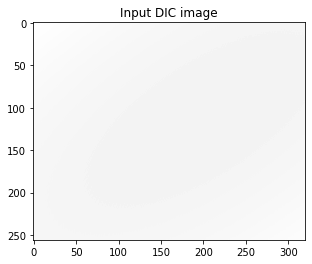

In [251]:
xx, yy = np.meshgrid(np.arange(1, ncols+1), np.arange(1, nrows+1))
xx = xx.flatten(); yy = yy.flatten()
X = np.column_stack((np.ones(N), xx, yy, xx**2, xx*yy, yy**2))
p = np.linalg.lstsq(X, f.flatten(), rcond=None)[0]

f = np.reshape(f.flatten()-np.dot(X, p), (nrows,ncols))
f = f/np.max(np.abs(f)) #image value in [-1,1]
plt.imshow(f,cmap='gray', vmin=-1, vmax=1); plt.title('Input DIC image'); plt.show()

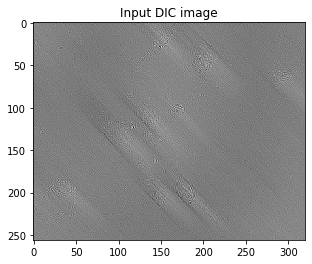

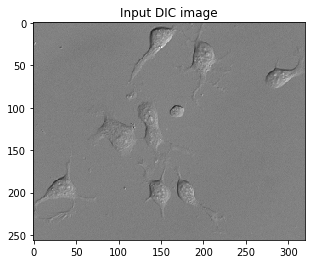

In [231]:
xx, yy = np.meshgrid(np.arange(1, ncols+1), np.arange(1, nrows+1))
xx = xx.flatten(); yy = yy.flatten()
X = np.column_stack((np.ones(N), xx, yy, xx**2, xx*yy, yy**2))
p = np.linalg.lstsq(X, g.flatten(), rcond=None)[0]
g = np.reshape(g.flatten()-np.dot(X, p), (nrows,ncols))
g = g/np.max(np.abs(g)) #image value in [-1,1]
plt.imshow(g,cmap='gray', vmin=-1, vmax=1); plt.title('Input DIC image'); plt.show()

In [48]:
np.diag([1,23])

array([[ 1,  0],
       [ 0, 23]])

In [51]:
vals.shape

(9, 81920)

In [115]:
indptr = np.array([0, 2, 3, 6])#0表示默认起始点，0之后有几个数字就表示有几行
indices = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
sp.csr_matrix((data, indices, indptr), shape=(3, 3)).toarray()


array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])

In [117]:
sp.csr_matrix((data, np.arange(6), np.arange(7)), shape=(6, 6)).toarray()

array([[1, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 6]])